In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
sys.path.append("../Scripts")

from data_cleaning import clean_prices, audit_data_quality
from compute_returns import compute_daily_returns, compute_mu_and_cov, save_outputs

# Read input directories
assert os.path.isdir("../Results/processed")
# Create output directories
os.makedirs("../Results/plots", exist_ok=True)

In [12]:
print("=" * 70)
print("STEP 1: LOADING RAW DATA")
print("=" * 70)

df = pd.read_csv("../Dataset/all_stocks_5yr.csv")
print(f"Loaded {len(df)} rows")
print(f"\nFirst 5 rows:")
print(df.head())

STEP 1: LOADING RAW DATA
Loaded 619040 rows

First 5 rows:
         date   open   high    low  close    volume Name
0  2013-02-08  15.07  15.12  14.63  14.75   8407500  AAL
1  2013-02-11  14.89  15.01  14.26  14.46   8882000  AAL
2  2013-02-12  14.45  14.51  14.10  14.27   8126000  AAL
3  2013-02-13  14.30  14.94  14.25  14.66  10259500  AAL
4  2013-02-14  14.94  14.96  13.16  13.99  31879900  AAL


In [13]:
print("\n" + "=" * 70)
print("STEP 2: EXPLORATORY DATA ANALYSIS")
print("=" * 70)

# Dataset shape
print(f"\nDataset Shape: {df.shape}")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

# Column data types
print("\nColumn Data Types:")
print(df.info())

# Check for null values
print("\nNull Values per Column:")
print(df.isnull().sum())
print(f"Total null values: {df.isnull().sum().sum()}")

# Check for duplicates
print(f"\nDuplicate rows: {df.duplicated().sum()}")

# Check for negative values
print("\nNegative Values Check:")
for column in df.select_dtypes(include=np.number).columns:
    neg_count = df[column][df[column] < 0].count()
    if neg_count > 0:
        print(f"  {column}: {neg_count} negative values")
    else:
        print(f"  {column}: ✔ No negative values")

# Summary statistics
print("\nSummary Statistics:")
print(df.describe())


STEP 2: EXPLORATORY DATA ANALYSIS

Dataset Shape: (619040, 7)
Rows: 619040, Columns: 7

Column Data Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  object 
 1   open    619029 non-null  float64
 2   high    619032 non-null  float64
 3   low     619032 non-null  float64
 4   close   619040 non-null  float64
 5   volume  619040 non-null  int64  
 6   Name    619040 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 33.1+ MB
None

Null Values per Column:
date       0
open      11
high       8
low        8
close      0
volume     0
Name       0
dtype: int64
Total null values: 27

Duplicate rows: 0

Negative Values Check:
  open: ✔ No negative values
  high: ✔ No negative values
  low: ✔ No negative values
  close: ✔ No negative values
  volume: ✔ No negative values

Summary Statistics:
          

In [14]:
print("\n" + "=" * 70)
print("STEP 3: DATA QUALITY AUDIT")
print("=" * 70)

# Convert date for audit
df_temp = df.copy()
df_temp["date"] = pd.to_datetime(df_temp["date"])

# Run comprehensive audit
audit_results = audit_data_quality(df_temp, verbose=True)

print("\nAudit Summary:")
print(f"  - Rows with Low > High: {audit_results['low_gt_high']}")
print(f"  - Rows with Bad Volume: {audit_results['bad_volume']}")
print(f"  - Rows with Bad Price: {audit_results['bad_price']}")


STEP 3: DATA QUALITY AUDIT
1. Rows where Low > High: 1
   Sample of bad logic:
            date Name    high    low
53002 2014-05-19  AOS  23.595  23.85
------------------------------
2. Rows with Volume <= 0: 4
   Sample of bad volume:
             date Name  volume
165857 2016-01-12  DHR       0
239832 2016-07-01  FTV       0
434502 2016-01-12    O       0
558213 2016-04-07   UA       0
------------------------------
3. Rows with Price <= 0: 0
   [OK] Price check passed.
------------------------------

Audit Summary:
  - Rows with Low > High: 1
  - Rows with Bad Volume: 4
  - Rows with Bad Price: 0



STEP 4: OUTLIER DETECTION


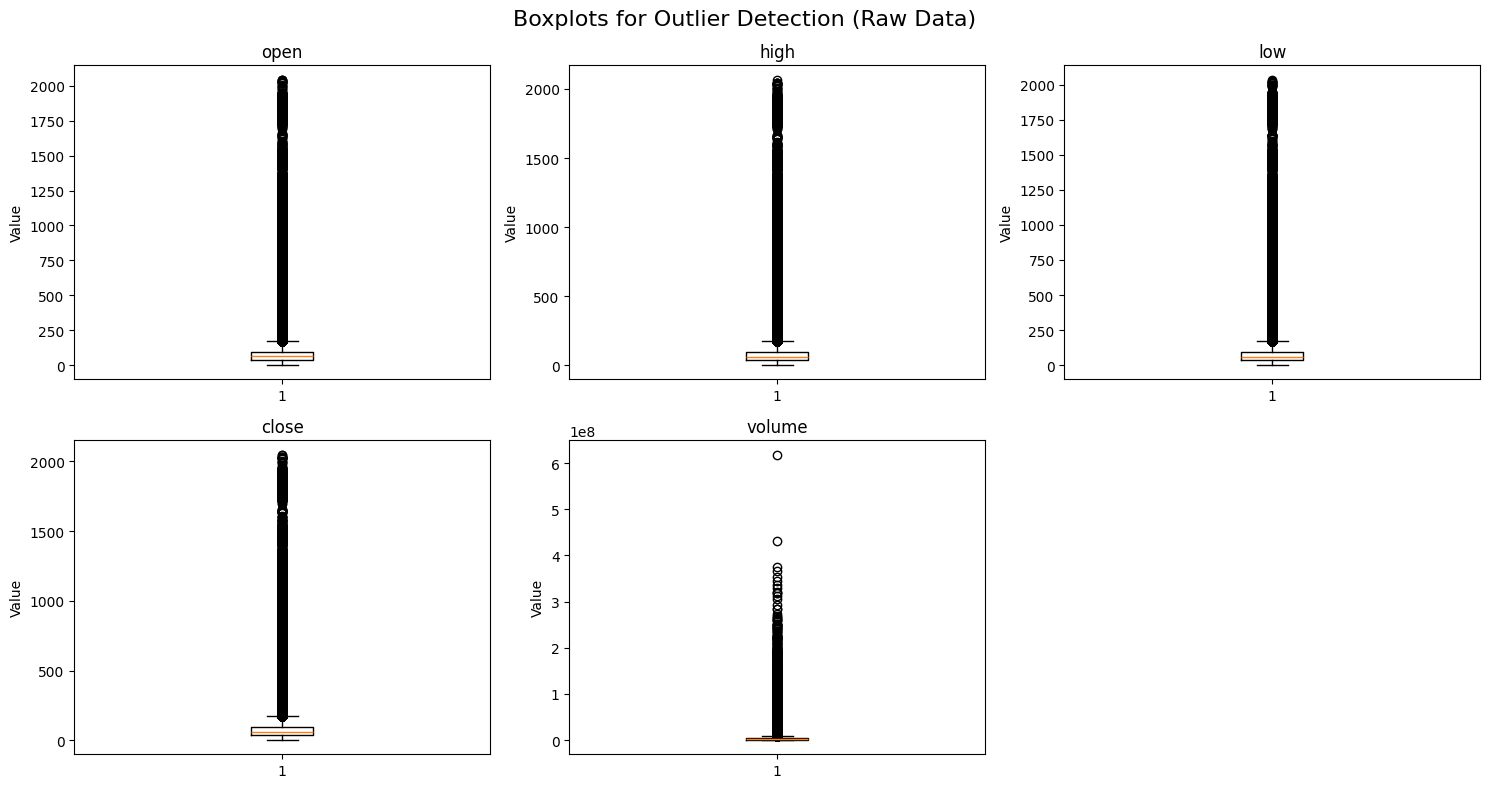

In [24]:
print("\n" + "=" * 70)
print("STEP 4: OUTLIER DETECTION")
print("=" * 70)

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Boxplots for Outlier Detection (Raw Data)', fontsize=16)

numeric_cols = ['open', 'high', 'low', 'close', 'volume']
for idx, column in enumerate(numeric_cols):
    row = idx // 3
    col = idx % 3
    axes[row, col].boxplot(df[column].dropna())
    axes[row, col].set_title(f'{column}')
    axes[row, col].set_ylabel('Value')

# Hide the extra subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()


In [16]:
print("\n" + "=" * 70)
print("STEP 5: DATA CLEANING")
print("=" * 70)

df["date"] = pd.to_datetime(df["date"])
df_clean = clean_prices(df, verbose=True)

print("\nCleaned Data Sample:")
print(df_clean.head())



STEP 5: DATA CLEANING
Initial rows: 619040
Removed 11 rows with missing values

--- DATA QUALITY AUDIT ---
1. Rows where Low > High: 1
   Sample of bad logic:
            date Name    high    low
53002 2014-05-19  AOS  23.595  23.85
------------------------------
2. Rows with Volume <= 0: 0
   [OK] Volume check passed.
------------------------------
3. Rows with Price <= 0: 0
   [OK] Price check passed.
------------------------------

Removed 1 rows where Low > High

--- FINAL DATA REPORT ---
Total Rows: 619028
Missing Values: 0
Unique Stocks: 505

Verification:
Remaining Logical Errors: 0
Remaining Zero/Negative Volume: 0
Remaining Zero/Negative Prices: 0

Cleaned Data Sample:
            date ticker   open   high    low  close   volume
71611 2013-02-08      A  45.07  45.35  45.00  45.08  1824755
71612 2013-02-11      A  45.17  45.18  44.45  44.60  2915405
71613 2013-02-12      A  44.81  44.95  44.50  44.62  2373731
71614 2013-02-13      A  44.81  45.24  44.68  44.75  2052338
71615 2

In [17]:
print("\n" + "=" * 70)
print("STEP 6: POST-CLEANING ANALYSIS")
print("=" * 70)

print(f"\nUnique tickers: {df_clean['ticker'].nunique()}")
print(f"Date range: {df_clean['date'].min()} to {df_clean['date'].max()}")
print(f"Total trading days: {df_clean['date'].nunique()}")

# Stocks with most data points
print("\nTop 10 stocks by data points:")
top_stocks = df_clean['ticker'].value_counts().head(10)
print(top_stocks)


STEP 6: POST-CLEANING ANALYSIS

Unique tickers: 505
Date range: 2013-02-08 00:00:00 to 2018-02-07 00:00:00
Total trading days: 1259

Top 10 stocks by data points:
ticker
ZTS     1259
A       1259
AAL     1259
AAP     1259
AAPL    1259
ABBV    1259
ABC     1259
ABT     1259
ACN     1259
ADBE    1259
Name: count, dtype: int64


In [19]:
print("\n" + "=" * 70)
print("STEP 7: COMPUTING RETURNS AND STATISTICS")
print("=" * 70)

df_returns = compute_daily_returns(df_clean)
print(f"Computed returns for {len(df_returns)} data points")

mu, cov, tickers = compute_mu_and_cov(df_returns)

print(f"\nNumber of tickers: {len(tickers)}")
print(f"Expected returns (μ) - first 5 stocks:")
for i in range(min(5, len(tickers))):
    print(f"  {tickers[i]}: {mu[i]:.6f}")

print(f"\nCovariance matrix shape: {cov.shape}")



STEP 7: COMPUTING RETURNS AND STATISTICS
Computed returns for 618523 data points

Number of tickers: 467
Expected returns (μ) - first 5 stocks:
  A: 0.000453
  AAL: 0.001245
  AAP: 0.000443
  AAPL: 0.000786
  ABBV: 0.001050

Covariance matrix shape: (467, 467)



STEP 8: CREATING VISUALIZATIONS


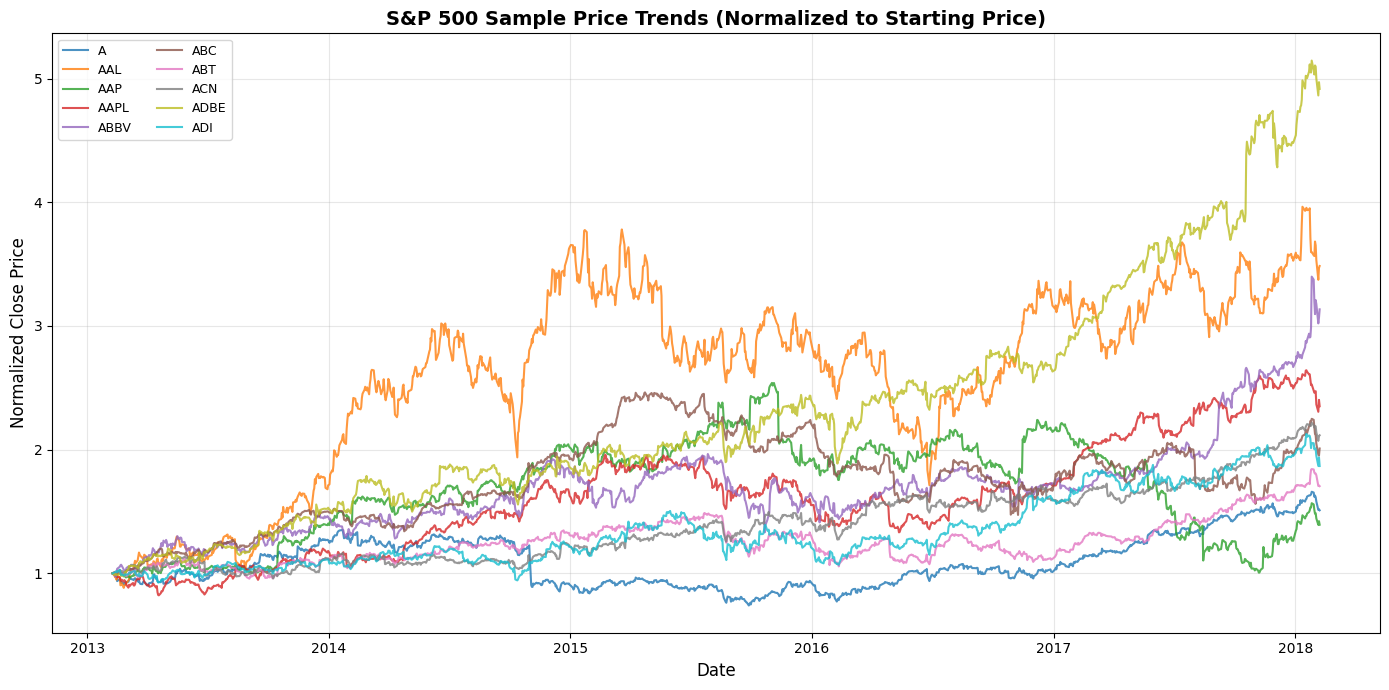

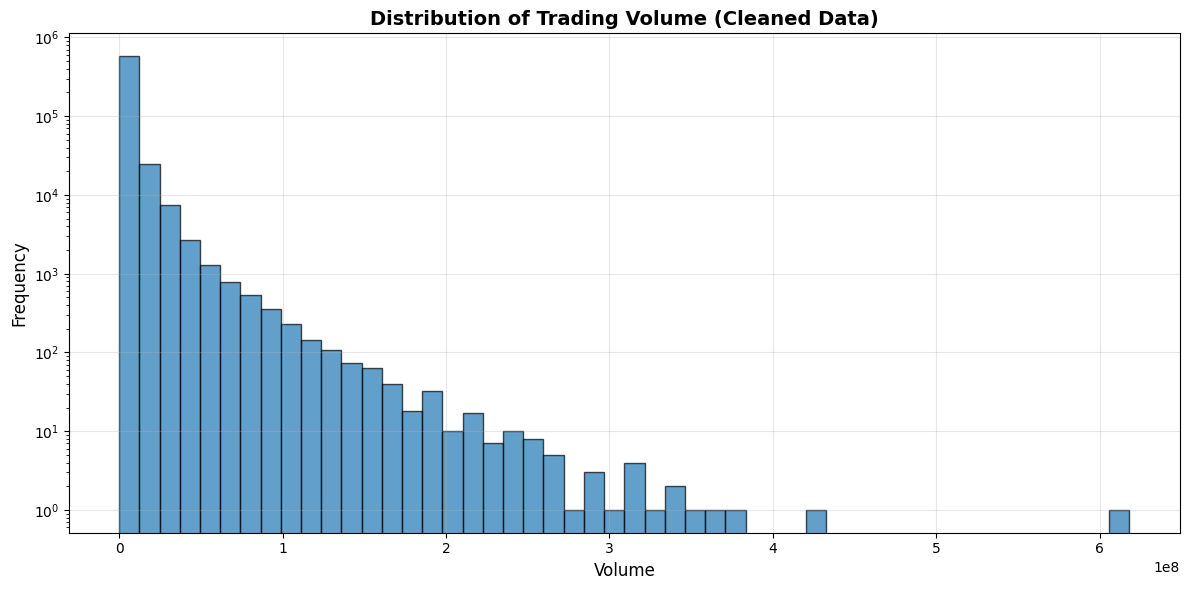

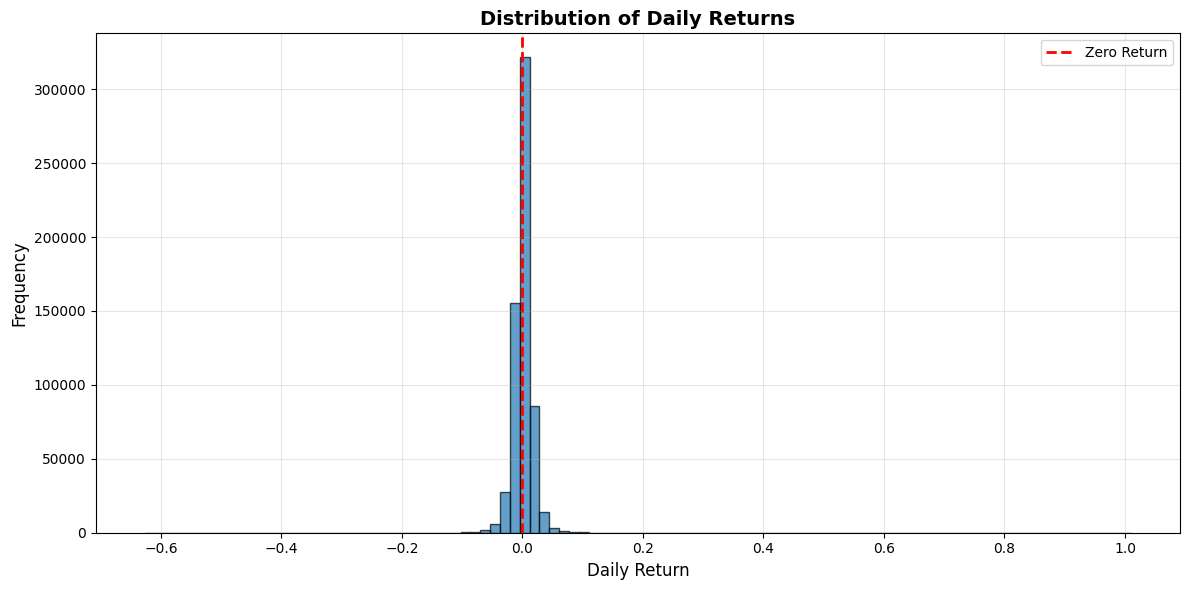

In [23]:
print("\n" + "=" * 70)
print("STEP 8: CREATING VISUALIZATIONS")
print("=" * 70)

# Plot 1: Sample Price Trends (Normalized)
plt.figure(figsize=(14, 7))
sample_tickers = tickers[:10]  # first 10 tickers

for name, sub in df_clean[df_clean["ticker"].isin(sample_tickers)].groupby("ticker"):
    s = sub.sort_values("date")
    # Normalize to start at 1.0
    norm = s["close"] / s["close"].iloc[0]
    plt.plot(s["date"], norm, label=name, linewidth=1.5, alpha=0.8)

plt.title("S&P 500 Sample Price Trends (Normalized to Starting Price)", fontsize=14, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Normalized Close Price", fontsize=12)
plt.legend(ncol=2, fontsize=9, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 2: Volume Distribution
plt.figure(figsize=(12, 6))
plt.hist(df_clean['volume'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Trading Volume (Cleaned Data)', fontsize=14, fontweight='bold')
plt.xlabel('Volume', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.yscale('log')  # Log scale for better visibility
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Plot 3: Returns Distribution
plt.figure(figsize=(12, 6))
all_returns = df_returns.dropna()['return'].values
plt.hist(all_returns, bins=100, edgecolor='black', alpha=0.7)
plt.title('Distribution of Daily Returns', fontsize=14, fontweight='bold')
plt.xlabel('Daily Return', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
print("\n" + "=" * 70)
print("FINAL SUMMARY REPORT")
print("=" * 70)

print(f"""
Data Processing Complete!

Raw Data:
  - Total rows: {len(df)}
  - Columns: {len(df.columns)}

Cleaned Data:
  - Total rows: {len(df_clean)}
  - Rows removed: {len(df) - len(df_clean)}
  - Unique tickers: {df_clean['ticker'].nunique()}
  - Date range: {df_clean['date'].min().date()} to {df_clean['date'].max().date()}

Quality Checks:
  - No missing values: {df_clean.isnull().sum().sum() == 0}
  - No logical errors (low > high): {len(df_clean[df_clean['low'] > df_clean['high']]) == 0}
  - No invalid volumes: {len(df_clean[df_clean['volume'] <= 0]) == 0}
  - No invalid prices: {len(df_clean[df_clean['close'] <= 0]) == 0}

print("=" * 70)
print("PROCESSING COMPLETE!")
print("=" * 70)


FINAL SUMMARY REPORT

Data Processing Complete!

Raw Data:
  - Total rows: 619040
  - Columns: 7

Cleaned Data:
  - Total rows: 619028
  - Rows removed: 12
  - Unique tickers: 505
  - Date range: 2013-02-08 to 2018-02-07

Quality Checks:
  - No missing values: True
  - No logical errors (low > high): True
  - No invalid volumes: True
  - No invalid prices: True

Outputs Saved:
  ✓ ../Results/plots/S&P_price_trends.png
  ✓ ../Results/plots/outliers_raw_data.png
  ✓ ../Results/plots/volume_distribution.png
  ✓ ../Results/plots/returns_distribution.png

PROCESSING COMPLETE!
